In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

2022-08-06 12:50:27.057597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 12:50:27.057623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Size of our input images
SIZE = 128
batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = datagen.flow_from_directory(
    "../../data/chest_xray/train/",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode="input"
    )

validation_generator = datagen.flow_from_directory(
    '../../data/chest_xray/test/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )
anomaly_generator = datagen.flow_from_directory(
    '../../data/chest_xray/PN_test_copy/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

Found 1341 images belonging to 1 classes.
Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.


In [4]:
#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

2022-08-06 12:50:29.317354: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-06 12:50:29.317383: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-06 12:50:29.317646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#Fit the model. 
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

Epoch 1/10
7/7 [==============================] - 10s 1s/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 8/10
7/7 [==============================] - 10s 1s/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0

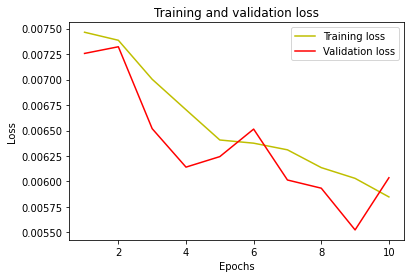

In [35]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

In [37]:
predicted = model.predict(data_batch[0])  #Predict on the first batch of images

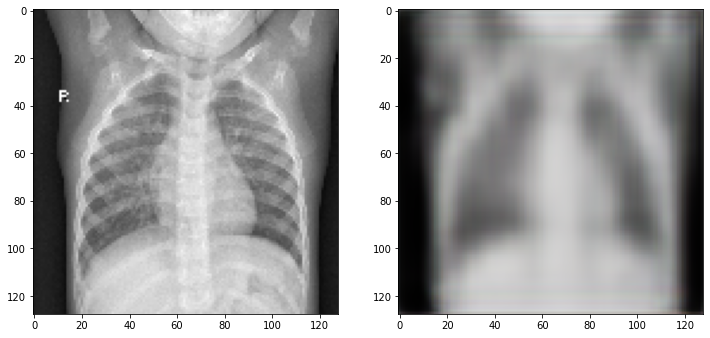

In [40]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [42]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

7/7 [==============================] - 1s 158ms/step - loss: 0.0044 - mse: 0.0044
Recon. error for the validation (normal) data is:  [0.006142543628811836, 0.006142543628811836]
Recon. error for the anomaly data is:  [0.004422091878950596, 0.004422091878950596]


In [43]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 16)      

In [44]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

In [45]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

In [46]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [47]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 19ms/step - loss: 0.0035 - mse: 0.0035


In [48]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

In [49]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('../../data/chest_xray/PN_test_copy/PNEUMONIA/*')
uninfected_file_paths = glob.glob('../../data/chest_xray/train/NORMAL/*')

In [50]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

ValueError: empty range for randrange() (0, 0, 0)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

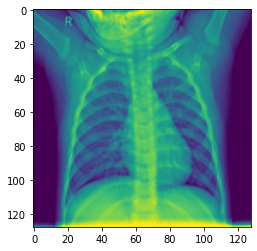

In [ ]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])